In [42]:
import keras
import sqlite3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import data as tf_data

In [43]:
STATES = {
    'CA': 0,
    'NM': 1,
    'OR': 2,
    'NC': 3,
    'WY': 4,
    'CO': 5,
    'WA': 6,
    'MT': 7,
    'UT': 8,
    'AZ': 9,
    'SD': 10,
    'AR': 11,
    'NV': 12,
    'ID': 13,
    'MN': 14,
    'TX': 15,
    'FL': 16,
    'SC': 17,
    'LA': 18,
    'OK': 19,
    'KS': 20,
    'MO': 21,
    'NE': 22,
    'MI': 23,
    'KY': 24,
    'OH': 25,
    'IN': 26,
    'VA': 27,
    'IL': 28,
    'TN': 29,
    'GA': 30,
    'AK': 31,
    'ND': 32,
    'WV': 33,
    'WI': 34,
    'AL': 35,
    'NH': 36,
    'PA': 37,
    'MS': 38,
    'ME': 39,
    'VT': 40,
    'NY': 41,
    'IA': 42,
    'DC': 43,
    'MD': 44,
    'CT': 45,
    'MA': 46,
    'NJ': 47,
    'HI': 48,
    'DE': 49,
    'PR': 50,
    'RI': 51
}

CLASS_MAP = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

In [44]:
def parse_dataset():
    connection = sqlite3.connect("../backend/database.sqlite")

    train_states = []
    train_dates = []
    train_labels = []
    test_states = []
    test_dates = []
    test_labels = []

    fires = connection.cursor().execute(
        "SELECT FIRE_SIZE_CLASS, STATE, DISCOVERY_DOY FROM Fires",
    ).fetchall()

    i = 0
    train_cutoff = round(len(fires) * 0.8)
    for fire in tqdm(fires):
        i+= 1

        fire_class = CLASS_MAP[fire[0]]
        state = STATES[fire[1]]
        date = fire[2] / 365
        if i < train_cutoff:
            train_states.append([state])
            train_dates.append([date])
            train_labels.append(fire_class)
        else:
            test_states.append([state])
            test_dates.append([date])
            test_labels.append(fire_class)

    return (
        (np.array(train_states), np.array(train_dates)),
        (np.array(test_states), np.array(test_dates)),
        np.array(train_labels),
        np.array(test_labels),
    )

In [45]:
NUM_CLASSES=7
BATCH_SIZE=512

(train_inputs, test_inputs, train_labels, test_labels) = parse_dataset()
train_states, train_dates = train_inputs
test_states, test_dates = test_inputs

100%|██████████| 1880465/1880465 [00:01<00:00, 1061296.27it/s]


In [46]:
dataset = tf_data.Dataset.from_tensor_slices(
    ((train_states, train_dates), train_labels)
)
dataset = dataset.shuffle(buffer_size=1024)
train_size = int(len(dataset) * 0.8)
validation_size = int(len(dataset) * 0.2)
train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_size).take(validation_size).batch(BATCH_SIZE)

test_dataset = tf_data.Dataset.from_tensor_slices(
    ((test_states, test_dates), test_labels)
)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [47]:
# Model
input_state = keras.Input(shape=(1,))
input_date = keras.Input(shape=(1,))
state_embed = keras.layers.Embedding(input_dim=52, output_dim=15)(input_state)
state_flatten = keras.layers.Flatten()(state_embed)
date_dense = keras.layers.Dense(15, activation="relu")(input_date)

# Concatenate processed inputs
concat = keras.layers.Concatenate()([state_flatten, date_dense])

# Deep network with residual connections
x = keras.layers.Dense(256, activation="relu")(concat)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

# Residual block 1
x_skip = x
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])
x = keras.layers.Dropout(0.3)(x)

# Residual block 2
x_skip = x
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])
x = keras.layers.Dropout(0.3)(x)

# Output layer
output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Build and compile model
model = keras.Model(inputs=[input_state, input_date], outputs=output)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 15)     │        780 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 15)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 15)        │         30 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 30)        │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │      7,936 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │     65,792 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_31[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ add_8[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     65,792 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_33[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 278,833 (1.06 MB)

 Trainable params: 276,273 (1.05 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [48]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"]
)

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.0804 - sparse_categorical_accuracy: 0.3654 - val_loss: 0.9920 - val_sparse_categorical_accuracy: 0.5951
Epoch 2/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 1.1315 - sparse_categorical_accuracy: 0.5287 - val_loss: 0.9625 - val_sparse_categorical_accuracy: 0.6203
Epoch 3/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 1.0812 - sparse_categorical_accuracy: 0.5557 - val_loss: 0.9628 - val_sparse_categorical_accuracy: 0.5826
Epoch 4/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.5630 - val_loss: 0.9625 - val_sparse_categorical_accuracy: 0.5828
Epoch 5/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 1.0607 - sparse_categorical_accuracy: 0.5658 - val_loss: 0.9677 - val_sparse_categorical_accuracy: 0.5829
Epoch 6/20
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 1.0553 - sparse_categorical_accuracy: 0.5682 - val_loss: 0.9694 - val_sparse_categorica

In [49]:
model.save("model.keras")
model.save("model.h5")

/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_64193/1937279587.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_64193/1937279587.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_64193/1937279587.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_64193/1937279587.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1

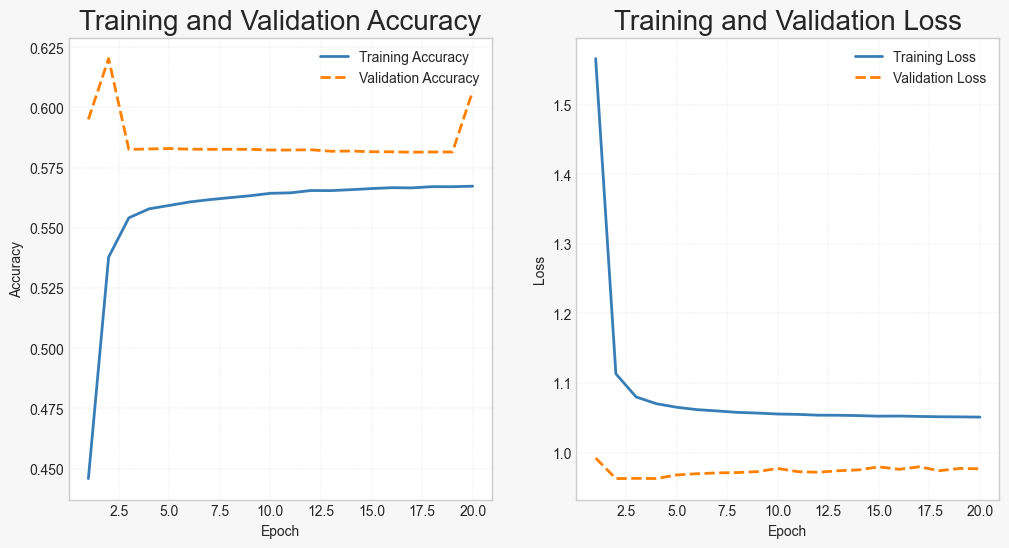

In [50]:
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#377eb8", "#ff7f00"]
linestyles = ["-", "--"]

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor("#f7f7f7")

plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy", fontsize=20)
plt.plot(
    epochs,
    acc,
    "r",
    label="Training Accuracy",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_acc,
    "b",
    label="Validation Accuracy",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.subplot(1, 2, 2)
plt.title("Training and Validation Loss", fontsize=20)
plt.plot(
    epochs,
    loss,
    "r",
    label="Training Loss",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_loss,
    "b",
    label="Validation Loss",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.savefig("training-and-validation-accuracy-and-loss.png")
plt.show()

In [51]:
model.evaluate(test_dataset)

735/735 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0481 - sparse_categorical_accuracy: 0.6235


[1.040102243423462, 0.6266385316848755]